# Brady Hobson, Sara Kent
# DS4420
# Final Project Python - Time Series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

In [2]:
lmp_df = pd.read_csv('lmp_data.csv')
print(lmp_df.head())

        interval_start_local         interval_start_utc  \
0  2024-01-01T00:00:00-05:00  2024-01-01 05:00:00+00:00   
1  2024-01-01T01:00:00-05:00  2024-01-01 06:00:00+00:00   
2  2024-01-01T02:00:00-05:00  2024-01-01 07:00:00+00:00   
3  2024-01-01T03:00:00-05:00  2024-01-01 08:00:00+00:00   
4  2024-01-01T04:00:00-05:00  2024-01-01 09:00:00+00:00   

          interval_end_local           interval_end_utc              location  \
0  2024-01-01T01:00:00-05:00  2024-01-01 06:00:00+00:00  AR.BEARSWMP13.8BSW1P   
1  2024-01-01T02:00:00-05:00  2024-01-01 07:00:00+00:00  AR.BEARSWMP13.8BSW1P   
2  2024-01-01T03:00:00-05:00  2024-01-01 08:00:00+00:00  AR.BEARSWMP13.8BSW1P   
3  2024-01-01T04:00:00-05:00  2024-01-01 09:00:00+00:00  AR.BEARSWMP13.8BSW1P   
4  2024-01-01T05:00:00-05:00  2024-01-01 10:00:00+00:00  AR.BEARSWMP13.8BSW1P   

  location_type    lmp  energy  congestion  loss  
0  NETWORK NODE  51.98   53.36         0.0 -1.38  
1  NETWORK NODE  35.07   35.60         0.0 -0.53  
2  NE

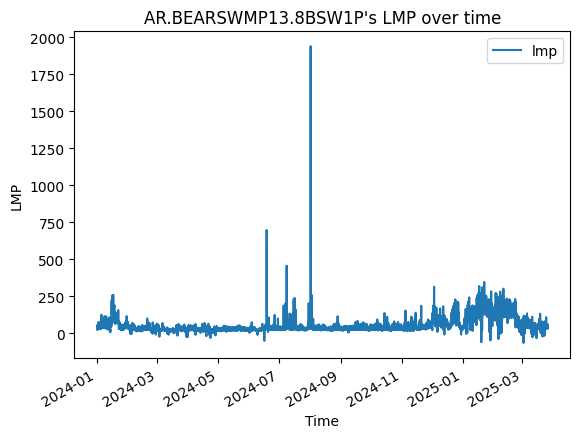

In [3]:
time = pd.to_datetime(lmp_df['interval_start_utc'])
lmp = lmp_df[['interval_start_utc', 'lmp']]
lmp.set_index('interval_start_utc', inplace=True)
lmp.index = pd.to_datetime(lmp.index)

lmp.plot()
plt.xlabel('Time')
plt.ylabel('LMP')
plt.title("AR.BEARSWMP13.8BSW1P's LMP over time")
plt.show()


## ARIMA

In [18]:
# split into train and test data 
train_size = int(.8 * len(lmp))
train_data = lmp[:train_size]
test_data = lmp[train_size:]

# ARIMA model
y_train = np.array(train_data['lmp']).reshape(-1,1)
y_test = np.array(test_data['lmp']).reshape(-1,1)
model = ARIMA(y_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8639
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -39616.712
Date:                Sun, 30 Mar 2025   AIC                          79245.423
Time:                        15:20:38   BIC                          79287.807
Sample:                             0   HQIC                         79259.875
                               - 8639                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0881      0.001    -71.115      0.000      -0.091      -0.086
ar.L2         -0.2961      0.002   -154.802      0.000      -0.300      -0.292
ar.L3         -0.1482      0.002    -84.167      0.0

/var/folders/nw/_17hsb7d5350llr4nk37tj2r0000gn/T/ipykernel_3904/2904791233.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['forecast'] = forecast


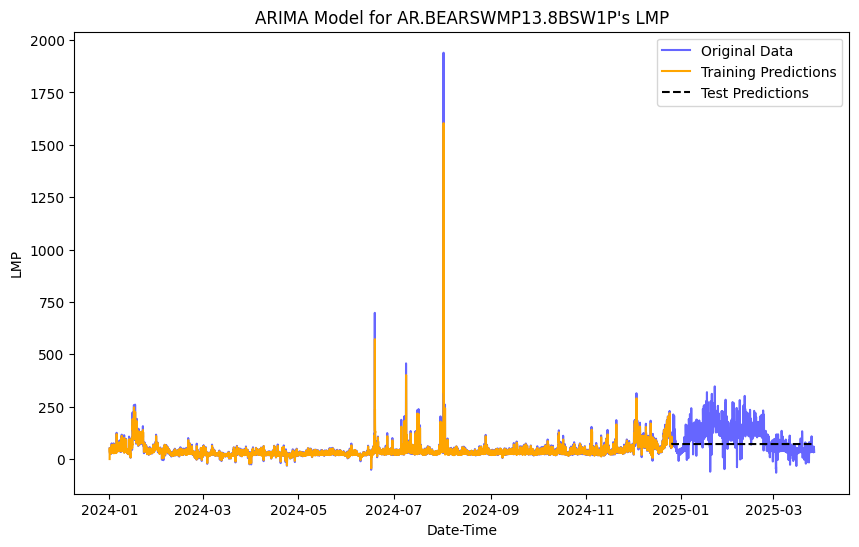

In [33]:
training_predictions = model_fit.fittedvalues

# forecasted data on test set
forecast = model_fit.forecast(steps=len(test_data))

test_data['forecast'] = forecast
test_preds = model_fit.forecast(steps=len(test_data))

# plot
plt.figure(figsize=(10,6))
plt.plot(lmp, label="Original Data", color="blue", alpha=0.6)
plt.plot(train_data.index, training_predictions, label="Training Predictions", color="orange")
plt.plot(test_data.index, test_data['forecast'], label="Test Predictions", color="black", linestyle="dashed")
plt.xlabel("Date-Time")
plt.ylabel("LMP")
plt.title("ARIMA Model for AR.BEARSWMP13.8BSW1P's LMP")
plt.legend()
plt.show()

## MA(1)

In [6]:
ma_pred = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'date_time': test_data.index, 'pred lmp': ma_pred.flatten()})
pred_data.set_index('date_time', inplace = True)
pred_data.head()

,pred lmp
date_time,
2024-12-26 04:00:00+00:00,70.771792
2024-12-26 05:00:00+00:00,71.918686
2024-12-26 06:00:00+00:00,73.508470
2024-12-26 07:00:00+00:00,72.752018
2024-12-26 08:00:00+00:00,71.576351


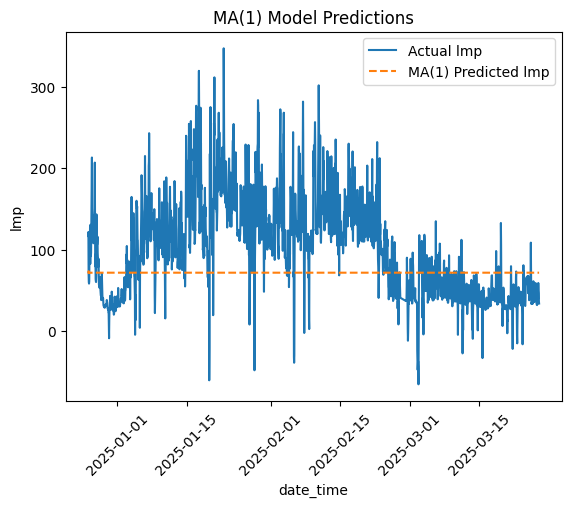

In [7]:
plt.plot(test_data['lmp'], label = 'Actual lmp')
plt.plot(pred_data['pred lmp'], label = 'MA(1) Predicted lmp', linestyle = '--')
plt.xlabel('date_time')
plt.ylabel('lmp')
plt.legend()
plt.title('MA(1) Model Predictions')
plt.xticks(rotation = 45)
plt.show()

## AR()